In [ ]:
"""
This section is a material informatics project aiming to build a quantitative composition-structure-property (QSPR) relationship between palladium-based alloys membranes and their hydrogen permeability.
...
"""

'\nThis section is a material informatics project aiming to build a quantitative composition-structure-property (QSPR) relationship between palladium-based alloys membranes and their hydrogen permeability.\n...\n'

In [ ]:
# Do not disconnect me during trianing (won't save you more than 24hours)
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>

In [ ]:
%%time
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.7 MB/s eta 0:00:00
CPU times: user 1.93 s, sys: 792 ms, total: 2.73 s
Wall time: 11.7 s


In [ ]:
%%time
# # Fresh Colab notebook
# # !pip install rdkit
# # !pip install xenonpy
!pip install pymatgen matminer
!pip install CBFV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 41.0 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=435

In [ ]:
%%time
# GPU checking
!/usr/local/cuda/bin/nvcc --version
!nvidia-smib

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
/bin/bash: line 1: nvidia-smib: command not found
CPU times: user 4.88 ms, sys: 2.9 ms, total: 7.79 ms
Wall time: 207 ms


In [ ]:
%%time
# Check which GPU we are using
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found
CPU times: user 3.16 ms, sys: 1.03 ms, total: 4.19 ms
Wall time: 103 ms


In [ ]:
%%time
# Import useful packages and dependencies
import os
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike
import scipy
from scipy import stats
import math
import statistics

import CBFV
from CBFV.composition import generate_features
from pymatgen.core import Element, Composition
from matminer.featurizers.composition import ElementFraction
from matminer.featurizers.conversions import StrToComposition

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.base import clone

from typing import Tuple, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec # For more fine-grained layout control of parity plot and shap
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize

import seaborn as sns

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina' #Allow image to have high resolution
np.random.seed(42) # Ensure reproducibility

CPU times: user 2.97 s, sys: 242 ms, total: 3.22 s
Wall time: 2.62 s


In [ ]:
%%time
# Import the machine learning models
import catboost
from catboost import CatBoostRegressor, Pool

CPU times: user 103 ms, sys: 19.1 ms, total: 122 ms
Wall time: 359 ms


In [ ]:
%%time
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 842 ms, sys: 147 ms, total: 989 ms
Wall time: 34.9 s


In [ ]:
# Setting this options allow Pandas to display every columns. By default only few are displayed.
%%time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

CPU times: user 56 µs, sys: 9 µs, total: 65 µs
Wall time: 67 µs


In [ ]:
%%time
# Load Experimental features datasets from GDrive
PATH_train_70= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_train_70.pkl'
PATH_test_70= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_test_70.pkl'

PATH_train_80= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_train_80.pkl'
PATH_test_80= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_test_80.pkl'

PATH_train_90= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_train_90.pkl'
PATH_test_90= '/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/Experimental_cond_test_90.pkl'

#%%
exp_cond_train_70=pd.read_pickle(PATH_train_70)
exp_cond_test_70=pd.read_pickle(PATH_test_70)

exp_cond_train_80=pd.read_pickle(PATH_train_80)
exp_cond_test_80=pd.read_pickle(PATH_test_80)

exp_cond_train_90=pd.read_pickle(PATH_train_90)
exp_cond_test_90=pd.read_pickle(PATH_test_90)

#%% Drop few columns
exp_cond_train_70=exp_cond_train_70.drop(columns=['Bravais lattice', 'Chemical group'])
exp_cond_train_80=exp_cond_train_80.drop(columns=['Bravais lattice', 'Chemical group'])
exp_cond_train_90=exp_cond_train_90.drop(columns=['Bravais lattice', 'Chemical group'])

exp_cond_test_70=exp_cond_test_70.drop(columns=['Bravais lattice', 'Chemical group'])
exp_cond_test_80=exp_cond_test_80.drop(columns=['Bravais lattice', 'Chemical group'])
exp_cond_test_90=exp_cond_test_90.drop(columns=['Bravais lattice', 'Chemical group'])

CPU times: user 12 ms, sys: 2.69 ms, total: 14.7 ms
Wall time: 2.12 s


In [ ]:
%%time
#%%
#Bond_properties
path_bond_properties_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_train_70.pkl'
path_bond_properties_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_test_70.pkl'

path_bond_properties_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_train_80.pkl'
path_bond_properties_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_test_80.pkl'

path_bond_properties_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_train_90.pkl'
path_bond_properties_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/bond_properties_test_90.pkl'

#%%
#Bond_properties
bond_properties_train_70 = pd.read_pickle(path_bond_properties_train_70)
bond_properties_test_70 = pd.read_pickle(path_bond_properties_test_70)

bond_properties_train_80 = pd.read_pickle(path_bond_properties_train_80)
bond_properties_test_80 = pd.read_pickle(path_bond_properties_test_80)

bond_properties_train_90 = pd.read_pickle(path_bond_properties_train_90)
bond_properties_test_90 = pd.read_pickle(path_bond_properties_test_90)

CPU times: user 6.28 ms, sys: 999 µs, total: 7.27 ms
Wall time: 2.05 s


In [ ]:
%%time
#%%
#Composition-Based Feature Vectors
path_cbfv_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_train_70.pkl'
path_cbfv_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_test_70.pkl'

path_cbfv_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_train_80.pkl'
path_cbfv_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_test_80.pkl'

path_cbfv_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_train_90.pkl'
path_cbfv_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/cbfv_df_test_90.pkl'

#%%
cbfv_df_train_70=pd.read_pickle(path_cbfv_train_70)
cbfv_df_test_70=pd.read_pickle(path_cbfv_test_70)

cbfv_df_train_80=pd.read_pickle(path_cbfv_train_80)
cbfv_df_test_80=pd.read_pickle(path_cbfv_test_80)

cbfv_df_train_90=pd.read_pickle(path_cbfv_train_90)
cbfv_df_test_90=pd.read_pickle(path_cbfv_test_90)

CPU times: user 13.2 ms, sys: 4.67 ms, total: 17.8 ms
Wall time: 2.46 s


In [ ]:
%%time
#%%
#Elemental
path_element_block_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_train_70.pkl'
path_element_block_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_test_70.pkl'

path_element_block_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_train_80.pkl'
path_element_block_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_test_80.pkl'

path_element_block_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_train_90.pkl'
path_element_block_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Resut_Data_cleaning/element_block_test_90.pkl'

#%%
element_block_train_70=pd.read_pickle(path_element_block_train_70)
element_block_test_70=pd.read_pickle(path_element_block_test_70)

element_block_train_80=pd.read_pickle(path_element_block_train_80)
element_block_test_80=pd.read_pickle(path_element_block_test_80)

element_block_train_90=pd.read_pickle(path_element_block_train_90)
element_block_test_90=pd.read_pickle(path_element_block_test_90)

CPU times: user 3.44 ms, sys: 5.19 ms, total: 8.63 ms
Wall time: 1.89 s


In [ ]:
%%time
# Manually create the concatenated datasets

# Training dataset for train 80 ratio
Exp_Bond_train_70 = pd.concat([exp_cond_train_70, bond_properties_train_70], axis=1)
Exp_CBFV_train_70 = pd.concat([exp_cond_train_70, cbfv_df_train_70], axis=1)
Exp_Elemental_train_70 = pd.concat([exp_cond_train_70, element_block_train_70], axis=1)
Exp_Bond_CBFV_train_70 =  pd.concat([exp_cond_train_70, bond_properties_train_70, cbfv_df_train_70], axis=1)
Exp_Bond_Elemental_train_70 = pd.concat([exp_cond_train_70, bond_properties_train_70, element_block_train_70], axis=1)
Exp_CBFV_Elemental_train_70 = pd.concat([exp_cond_train_70, cbfv_df_train_70, element_block_train_70], axis=1)
Exp_Bond_CBFV_Elemental_train_70 = pd.concat([exp_cond_train_70, bond_properties_train_70, cbfv_df_train_70, element_block_train_70], axis=1)


# Training dataset for train 70 ratio
Exp_Bond_train_80 = pd.concat([exp_cond_train_80, bond_properties_train_80], axis=1)
Exp_CBFV_train_80 = pd.concat([exp_cond_train_80, cbfv_df_train_80], axis=1)
Exp_Elemental_train_80 = pd.concat([exp_cond_train_80, element_block_train_80], axis=1)
Exp_Bond_CBFV_train_80 =  pd.concat([exp_cond_train_80, bond_properties_train_80, cbfv_df_train_80], axis=1)
Exp_Bond_Elemental_train_80 = pd.concat([exp_cond_train_80, bond_properties_train_80, element_block_train_80], axis=1)
Exp_CBFV_Elemental_train_80 = pd.concat([exp_cond_train_80, cbfv_df_train_80, element_block_train_80], axis=1)
Exp_Bond_CBFV_Elemental_train_80 = pd.concat([exp_cond_train_80, bond_properties_train_80, cbfv_df_train_80, element_block_train_80], axis=1)


# Training dataset for train 90 ratio
Exp_Bond_train_90 = pd.concat([exp_cond_train_90, bond_properties_train_90], axis=1)
Exp_CBFV_train_90 = pd.concat([exp_cond_train_90, cbfv_df_train_90], axis=1)
Exp_Elemental_train_90 = pd.concat([exp_cond_train_90, element_block_train_90], axis=1)
Exp_Bond_CBFV_train_90 =  pd.concat([exp_cond_train_90, bond_properties_train_90, cbfv_df_train_90], axis=1)
Exp_Bond_Elemental_train_90 = pd.concat([exp_cond_train_90, bond_properties_train_90, element_block_train_90], axis=1)
Exp_CBFV_Elemental_train_90 = pd.concat([exp_cond_train_90, cbfv_df_train_90, element_block_train_90], axis=1)
Exp_Bond_CBFV_Elemental_train_90 = pd.concat([exp_cond_train_90, bond_properties_train_90, cbfv_df_train_90, element_block_train_90], axis=1)

CPU times: user 29.7 ms, sys: 17.1 ms, total: 46.8 ms
Wall time: 49.8 ms


In [ ]:
%%time
# Training dataset for train 70 ratio
path_Exp_Bond_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_train_70.pkl'
path_Exp_CBFV_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_train_70.pkl'
path_Exp_Elemental_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_train_70.pkl'
path_Exp_Bond_CBFV_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_train_70.pkl'
path_Exp_Bond_Elemental_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_train_70.pkl'
path_Exp_CBFV_Elemental_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_train_70.pkl'
path_Exp_Bond_CBFV_Elemental_train_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_train_70.pkl'

Exp_Bond_train_70.to_pickle(path_Exp_Bond_train_70)
Exp_CBFV_train_70.to_pickle(path_Exp_CBFV_train_70)
Exp_Elemental_train_70.to_pickle(path_Exp_Elemental_train_70)
Exp_Bond_CBFV_train_70.to_pickle(path_Exp_Bond_CBFV_train_70)
Exp_Bond_Elemental_train_70.to_pickle(path_Exp_Bond_Elemental_train_70)
Exp_CBFV_Elemental_train_70.to_pickle(path_Exp_CBFV_Elemental_train_70)
Exp_Bond_CBFV_Elemental_train_70.to_pickle(path_Exp_Bond_CBFV_Elemental_train_70)

# Training dataset for train 80 ratio
path_Exp_Bond_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_train_80.pkl'
path_Exp_CBFV_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_train_80.pkl'
path_Exp_Elemental_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_train_80.pkl'
path_Exp_Bond_CBFV_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_train_80.pkl'
path_Exp_Bond_Elemental_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_train_80.pkl'
path_Exp_CBFV_Elemental_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_train_80.pkl'
path_Exp_Bond_CBFV_Elemental_train_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_train_80.pkl'

Exp_Bond_train_80.to_pickle(path_Exp_Bond_train_80)
Exp_CBFV_train_80.to_pickle(path_Exp_CBFV_train_80)
Exp_Elemental_train_80.to_pickle(path_Exp_Elemental_train_80)
Exp_Bond_CBFV_train_80.to_pickle(path_Exp_Bond_CBFV_train_80)
Exp_Bond_Elemental_train_80.to_pickle(path_Exp_Bond_Elemental_train_80)
Exp_CBFV_Elemental_train_80.to_pickle(path_Exp_CBFV_Elemental_train_80)
Exp_Bond_CBFV_Elemental_train_80.to_pickle(path_Exp_Bond_CBFV_Elemental_train_80)

# Training dataset for train 90 ratio
path_Exp_Bond_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_train_90.pkl'
path_Exp_CBFV_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_train_90.pkl'
path_Exp_Elemental_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_train_90.pkl'
path_Exp_Bond_CBFV_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_train_90.pkl'
path_Exp_Bond_Elemental_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_train_90.pkl'
path_Exp_CBFV_Elemental_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_train_90.pkl'
path_Exp_Bond_CBFV_Elemental_train_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_train_90.pkl'

Exp_Bond_train_90.to_pickle(path_Exp_Bond_train_90)
Exp_CBFV_train_90.to_pickle(path_Exp_CBFV_train_90)
Exp_Elemental_train_90.to_pickle(path_Exp_Elemental_train_90)
Exp_Bond_CBFV_train_90.to_pickle(path_Exp_Bond_CBFV_train_90)
Exp_Bond_Elemental_train_90.to_pickle(path_Exp_Bond_Elemental_train_90)
Exp_CBFV_Elemental_train_90.to_pickle(path_Exp_CBFV_Elemental_train_90)
Exp_Bond_CBFV_Elemental_train_90.to_pickle(path_Exp_Bond_CBFV_Elemental_train_90)

CPU times: user 33.9 ms, sys: 17.1 ms, total: 51.1 ms
Wall time: 7.97 s


In [ ]:
%%time
# Test dataset for train 70 ratio
Exp_Bond_test_70 = pd.concat([exp_cond_test_70, bond_properties_test_70], axis=1)
Exp_CBFV_test_70 = pd.concat([exp_cond_test_70, cbfv_df_test_70], axis=1)
Exp_Elemental_test_70 = pd.concat([exp_cond_test_70, element_block_test_70], axis=1)
Exp_Bond_CBFV_test_70 =  pd.concat([exp_cond_test_70, bond_properties_test_70, cbfv_df_test_70], axis=1)
Exp_Bond_Elemental_test_70 = pd.concat([exp_cond_test_70, bond_properties_test_70, element_block_test_70], axis=1)
Exp_CBFV_Elemental_test_70 = pd.concat([exp_cond_test_70, cbfv_df_test_70, element_block_test_70], axis=1)
Exp_Bond_CBFV_Elemental_test_70 = pd.concat([exp_cond_test_70, bond_properties_test_70, cbfv_df_test_70, element_block_test_70], axis=1)

# Test dataset for train 80 ratio
Exp_Bond_test_80 = pd.concat([exp_cond_test_80, bond_properties_test_80], axis=1)
Exp_CBFV_test_80 = pd.concat([exp_cond_test_80, cbfv_df_test_80], axis=1)
Exp_Elemental_test_80 = pd.concat([exp_cond_test_80, element_block_test_80], axis=1)
Exp_Bond_CBFV_test_80 =  pd.concat([exp_cond_test_80, bond_properties_test_80, cbfv_df_test_80], axis=1)
Exp_Bond_Elemental_test_80 = pd.concat([exp_cond_test_80, bond_properties_test_80, element_block_test_80], axis=1)
Exp_CBFV_Elemental_test_80 = pd.concat([exp_cond_test_80, cbfv_df_test_80, element_block_test_80], axis=1)
Exp_Bond_CBFV_Elemental_test_80 = pd.concat([exp_cond_test_80, bond_properties_test_80, cbfv_df_test_80, element_block_test_80], axis=1)

# Test dataset for train 90 ratio
Exp_Bond_test_90 = pd.concat([exp_cond_test_90, bond_properties_test_90], axis=1)
Exp_CBFV_test_90 = pd.concat([exp_cond_test_90, cbfv_df_test_90], axis=1)
Exp_Elemental_test_90 = pd.concat([exp_cond_test_90, element_block_test_90], axis=1)
Exp_Bond_CBFV_test_90 =  pd.concat([exp_cond_test_90, bond_properties_test_90, cbfv_df_test_90], axis=1)
Exp_Bond_Elemental_test_90 = pd.concat([exp_cond_test_90, bond_properties_test_90, element_block_test_90], axis=1)
Exp_CBFV_Elemental_test_90 = pd.concat([exp_cond_test_90, cbfv_df_test_90, element_block_test_90], axis=1)
Exp_Bond_CBFV_Elemental_test_90 = pd.concat([exp_cond_test_90, bond_properties_test_90, cbfv_df_test_90, element_block_test_90], axis=1)


# test data path: 70 ratio (Actual train/test size is 80/20)
path_Exp_Bond_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_test_70.pkl'
path_Exp_CBFV_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_test_70.pkl'
path_Exp_Elemental_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_test_70.pkl'
path_Exp_Bond_CBFV_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_test_70.pkl'
path_Exp_Bond_Elemental_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_test_70.pkl'
path_Exp_CBFV_Elemental_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_test_70.pkl'
path_Exp_Bond_CBFV_Elemental_test_70='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_test_70.pkl'

Exp_Bond_test_70.to_pickle(path_Exp_Bond_test_70)
Exp_CBFV_test_70.to_pickle(path_Exp_CBFV_test_70)
Exp_Elemental_test_70.to_pickle(path_Exp_Elemental_test_70)
Exp_Bond_CBFV_test_70.to_pickle(path_Exp_Bond_CBFV_test_70)
Exp_Bond_Elemental_test_70.to_pickle(path_Exp_Bond_Elemental_test_70)
Exp_CBFV_Elemental_test_70.to_pickle(path_Exp_CBFV_Elemental_test_70)
Exp_Bond_CBFV_Elemental_test_70.to_pickle(path_Exp_Bond_CBFV_Elemental_test_70)

# test data path: 80 ratio (Actual train/test size is 85/15)
path_Exp_Bond_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_test_80.pkl'
path_Exp_CBFV_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_test_80.pkl'
path_Exp_Elemental_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_test_80.pkl'
path_Exp_Bond_CBFV_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_test_80.pkl'
path_Exp_Bond_Elemental_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_test_80.pkl'
path_Exp_CBFV_Elemental_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_test_80.pkl'
path_Exp_Bond_CBFV_Elemental_test_80='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_test_80.pkl'

Exp_Bond_test_80.to_pickle(path_Exp_Bond_test_80)
Exp_CBFV_test_80.to_pickle(path_Exp_CBFV_test_80)
Exp_Elemental_test_80.to_pickle(path_Exp_Elemental_test_80)
Exp_Bond_CBFV_test_80.to_pickle(path_Exp_Bond_CBFV_test_80)
Exp_Bond_Elemental_test_80.to_pickle(path_Exp_Bond_Elemental_test_80)
Exp_CBFV_Elemental_test_80.to_pickle(path_Exp_CBFV_Elemental_test_80)
Exp_Bond_CBFV_Elemental_test_80.to_pickle(path_Exp_Bond_CBFV_Elemental_test_80)

# test data path: 90 ratio (Actual train/test size is 95/5)
path_Exp_Bond_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_test_90.pkl'
path_Exp_CBFV_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_test_90.pkl'
path_Exp_Elemental_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Elemental_test_90.pkl'
path_Exp_Bond_CBFV_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_test_90.pkl'
path_Exp_Bond_Elemental_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_Elemental_test_90.pkl'
path_Exp_CBFV_Elemental_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_CBFV_Elemental_test_90.pkl'
path_Exp_Bond_CBFV_Elemental_test_90='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/Exp_Bond_CBFV_Elemental_test_90.pkl'

Exp_Bond_test_90.to_pickle(path_Exp_Bond_test_90)
Exp_CBFV_test_90.to_pickle(path_Exp_CBFV_test_90)
Exp_Elemental_test_90.to_pickle(path_Exp_Elemental_test_90)
Exp_Bond_CBFV_test_90.to_pickle(path_Exp_Bond_CBFV_test_90)
Exp_Bond_Elemental_test_90.to_pickle(path_Exp_Bond_Elemental_test_90)
Exp_CBFV_Elemental_test_90.to_pickle(path_Exp_CBFV_Elemental_test_90)
Exp_Bond_CBFV_Elemental_test_90.to_pickle(path_Exp_Bond_CBFV_Elemental_test_90)

CPU times: user 38.9 ms, sys: 8.89 ms, total: 47.8 ms
Wall time: 7.15 s


In [ ]:
%%time
# The code used here have been modified after Jeff Macaluso's proposed tutorial on his website
# Reference: https://macalusojeff.github.io/post/HyperparameterTuningXGB/
# Define the parameter distributions for hyperparameter tuning
# Using this guide: https://machinelearningmastery.com/configure-gradient-boosting-algorithm/
# Parameter documentation: https://xgboost.readthedocs.io/en/stable/parameter.html
# Reference to hyperparameter tuning by CatBoost developpers: https://github.com/catboost/catboost/blob/master/catboost/tutorials/hyperparameters_tuning/hyperparameters_tuning.ipynb


# A function for sampling hyperparameter distribution or discrete points
# def sample_from_param_distributions(param_distributions: dict) -> dict:

#     """
#     Sample a value from each parameter distribution defined in param_distributions.

#     Parameters:
#     - param_distributions (dict): Dictionary where keys are parameter names and values are either:
#         - scipy.stats distribution objects for continuous distributions.
#         - Lists or numpy arrays for discrete choices.

#     Returns:
#     - sampled_values (dict): Dictionary containing sampled values corresponding to each parameter.
#     """

#     sampled_values = {}
#     for param, distribution in param_distributions.items():
#         if isinstance(distribution, scipy.stats._distn_infrastructure.rv_frozen):
#             sampled_values[param] = distribution.rvs()
#         elif isinstance(distribution, list) or isinstance(distribution, np.ndarray):
#             sampled_values[param] = np.random.choice(distribution)
#         else:
#             raise ValueError(f"Unsupported distribution type for parameter '{param}'")
#     return sampled_values

def sample_from_param_distributions(param_distributions: dict, rng: np.random.Generator) -> dict:
    sampled = {}
    for name, dist in param_distributions.items():
        if hasattr(dist, "rvs"):  # scipy-like
            sampled[name] = dist.rvs(random_state=rng.integers(0, 2**31-1))
        elif isinstance(dist, (list, tuple, np.ndarray)):
            sampled[name] = rng.choice(dist)
        else:
            raise ValueError(f"Unsupported distribution for '{name}': {type(dist)}")
    return sampled


param_distributions = {
    "learning_rate": scipy.stats.uniform(loc=0.001, scale=0.199),  # 0.001–0.2
    "depth": np.arange(3, 14),  # Valid depths: 3–10
    "l2_leaf_reg": [2, 3, 5, 7, 10],  # L2 Regularization
    "random_strength": scipy.stats.uniform(loc=0, scale=10)  # Noise in split
}

# Function for manual hyperparameter tuning (Correct)
def hyperparameter_catboost(
    feature_dict: dict,
    param_distributions: dict,
    group_col: str,
    target_col: str,
    stratify_col: str,
    random_seed:int=42,
    num_iterations: int = 40,
    n_splits: list = [3, 5, 10],
    base_path: str = '/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling',
    autosave_path: str = '/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_70_CPU.pkl'
) -> pd.DataFrame:
    rng = np.random.default_rng(random_seed)
    results = []

    for split_ratio, combi_dict in feature_dict.items():
        for combi_name in combi_dict:
            file_path = os.path.join(base_path, f'{combi_name}_train_{split_ratio}.pkl')
            if not os.path.exists(file_path):
                print(f"⚠️ File not found: {file_path}")
                continue

            df_loaded = pd.read_pickle(file_path)

            if df_loaded.isnull().any().any():
                print(f"⚠️ NaNs found in {combi_name}_{split_ratio}. Skipping.")
                continue

            print(f"📂 Loaded: {combi_name}_{split_ratio}, shape = {df_loaded.shape}")

            stratify_labels = df_loaded[stratify_col]
            groups = df_loaded[group_col]
            target_var = df_loaded[target_col]
            drop_cols = [target_col, group_col, stratify_col]
            X = df_loaded.drop(columns=drop_cols, errors='ignore')

            for k in n_splits:
                sgkf = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_seed)
                splits = list(sgkf.split(X, y=stratify_labels, groups=groups))

                best_score = -np.inf
                best_params = None

                for _ in tqdm(range(num_iterations), desc=f"Tuning {combi_name} - {k}-Fold"):
                    sampled_params = sample_from_param_distributions(param_distributions, rng)

                    # Ensure proper dtypes
                    if "depth" in sampled_params: sampled_params["depth"] = int(sampled_params["depth"])
                    if "l2_leaf_reg" in sampled_params: sampled_params["l2_leaf_reg"] = float(sampled_params["l2_leaf_reg"])

                    cv_scores = []
                    cv_n_iterations = []

                    for fold_idx, (train_idx, val_idx) in enumerate(splits):
                        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                        y_train, y_val = target_var.iloc[train_idx], target_var.iloc[val_idx]

                        X_scaler = RobustScaler()
                        X_train_scaled = X_scaler.fit_transform(X_train)
                        X_val_scaled = X_scaler.transform(X_val)

                        y_train_transformed = np.log1p(y_train)
                        y_val_transformed = np.log1p(y_val)

                        model = CatBoostRegressor(
                            **sampled_params,
                            iterations=10000,
                            early_stopping_rounds=20,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            task_type="CPU",
                            thread_count=-1,
                            random_state=random_seed,
                            verbose=False
                        )

                        model.fit(X_train_scaled, y_train_transformed, use_best_model=True, eval_set=[(X_val_scaled, y_val_transformed)], verbose=False)
                        y_val_pred_transformed = model.predict(X_val_scaled)
                        y_val_pred = np.expm1(y_val_pred_transformed)

                        fold_score = -root_mean_squared_error(y_val, y_val_pred)
                        cv_scores.append(fold_score)
                        cv_n_iterations.append(model.get_best_iteration())

                    avg_score = np.mean(cv_scores)
                    std_score = np.std(cv_scores)

                    if avg_score>best_score:
                        best_score=avg_score
                        best_params=sampled_params.copy()
                        best_iter_mean = np.mean(cv_n_iterations)
                        best_iter_median = np.median(cv_n_iterations)

                        record = {
                            "split_ratio":split_ratio,
                            "combi_name":combi_name,
                            "n_split":k,
                            "cv_mean_rmse_score":best_score,
                            "std_score":std_score,
                            "model_name":'CatBoostRegressor',
                            "n_estimators_mean":best_iter_mean,
                            "n_estimators_median":best_iter_median,
                            "best_params":best_params,
                        }

                        results.append(record)

                        # ✅ Save current results after each improvement
                        pd.DataFrame(results).to_pickle(autosave_path)

    return pd.DataFrame(results)

CPU times: user 1.46 ms, sys: 10 µs, total: 1.47 ms
Wall time: 1.45 ms


In [ ]:
%%time
# Comments on data split
  # 70% --->80%
  # 80% --->85%
  # 90% --->95%

feature_dict= {
    # 90:{
    # 'Exp_Bond': Exp_Bond_train_90,
    # 'Exp_CBFV': Exp_CBFV_train_90,
    # 'Exp_Elemental': Exp_Elemental_train_90,
    # 'Exp_Bond_CBFV': Exp_Bond_CBFV_train_90,
    # 'Exp_Bond_Elemental': Exp_Bond_Elemental_train_90,
    # 'Exp_CBFV_Elemental': Exp_CBFV_Elemental_train_90,
    # 'Exp_Bond_CBFV_Elemental': Exp_Bond_CBFV_Elemental_train_90
    # },

    # 80:{
    # 'Exp_Bond': Exp_Bond_train_80,
    # 'Exp_CBFV': Exp_CBFV_train_80,
    # 'Exp_Elemental': Exp_Elemental_train_80,
    # 'Exp_Bond_CBFV': Exp_Bond_CBFV_train_80,
    # 'Exp_Bond_Elemental': Exp_Bond_Elemental_train_80,
    # 'Exp_CBFV_Elemental': Exp_CBFV_Elemental_train_80,
    # 'Exp_Bond_CBFV_Elemental': Exp_Bond_CBFV_Elemental_train_80
    # },

    70:{
    'Exp_Bond': Exp_Bond_train_70,
    'Exp_CBFV': Exp_CBFV_train_70,
    'Exp_Elemental': Exp_Elemental_train_70,
    'Exp_Bond_CBFV': Exp_Bond_CBFV_train_70,
    'Exp_Bond_Elemental': Exp_Bond_Elemental_train_70,
    'Exp_CBFV_Elemental': Exp_CBFV_Elemental_train_70,
    'Exp_Bond_CBFV_Elemental': Exp_Bond_CBFV_Elemental_train_70
    }
 }

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [ ]:
%%time
results_70_CPU=hyperparameter_catboost(
    feature_dict=feature_dict,
    param_distributions= param_distributions,
    group_col= 'Composition in mole percent',
    target_col= 'Permeability',
    stratify_col='Stratify Group',
    num_iterations=40,
    n_splits=[3, 5, 10],
    base_path='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling',
    autosave_path = '/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_70_CPU.pkl'
)

📂 Loaded: Exp_Bond_70, shape = (1788, 26)


Tuning Exp_Bond - 10-Fold: 100%|██████████| 40/40 [44:50<00:00, 67.27s/it]


📂 Loaded: Exp_CBFV_70, shape = (1788, 83)


Tuning Exp_CBFV - 10-Fold: 100%|██████████| 40/40 [1:46:47<00:00, 160.19s/it]


📂 Loaded: Exp_Elemental_70, shape = (1788, 48)


Tuning Exp_Elemental - 10-Fold: 100%|██████████| 40/40 [12:11<00:00, 18.29s/it]


📂 Loaded: Exp_Bond_CBFV_70, shape = (1788, 101)


Tuning Exp_Bond_CBFV - 10-Fold: 100%|██████████| 40/40 [2:12:19<00:00, 198.48s/it]


📂 Loaded: Exp_Bond_Elemental_70, shape = (1788, 66)


Tuning Exp_Bond_Elemental - 10-Fold: 100%|██████████| 40/40 [27:37<00:00, 41.44s/it]


📂 Loaded: Exp_CBFV_Elemental_70, shape = (1788, 123)


Tuning Exp_CBFV_Elemental - 10-Fold: 100%|██████████| 40/40 [2:06:35<00:00, 189.90s/it]


📂 Loaded: Exp_Bond_CBFV_Elemental_70, shape = (1788, 141)


Tuning Exp_Bond_CBFV_Elemental - 10-Fold: 100%|██████████| 40/40 [3:01:22<00:00, 272.06s/it]

CPU times: user 5d 2h 43min 42s, sys: 4h 4min 5s, total: 5d 6h 47min 48s
Wall time: 16h 49min 8s


In [ ]:
%%time
# results_90_CPU
# results_90_CPU.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_90_CPU.pkl')
# pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_80_CPU.pkl')
# '/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_80_BCBFVElem_CPU.pkl'
results_70_CPU = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_70_CPU.pkl')
result_80_first_CPU = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_80_CPU.pkl').iloc[:75, :]
result_80_remaining_CPU = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_80_BCBFVElem_CPU.pkl')
results_90_CPU = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_90_CPU.pkl')


HP_tuning_result_CPU = pd.concat([results_70_CPU,
                                  result_80_first_CPU,
                                  result_80_remaining_CPU,
                                  results_90_CPU], ignore_index=True)


CPU times: user 5.95 ms, sys: 1.02 ms, total: 6.97 ms
Wall time: 2.22 s


,split_ratio,combi_name,n_split,cv_mean_rmse_score,std_score,model_name,n_estimators_mean,n_estimators_median,best_params
0,70,Exp_Bond,3,-1.367360e-08,2.417544e-09,CatBoostRegressor,110.000000,110.0,"{'learning_rate': 0.1596878903467192, 'depth':..."
1,70,Exp_Bond,3,-1.334152e-08,2.392321e-09,CatBoostRegressor,177.666667,206.0,"{'learning_rate': 0.10897807095304271, 'depth'..."
2,70,Exp_Bond,3,-1.318608e-08,2.581995e-09,CatBoostRegressor,131.333333,126.0,"{'learning_rate': 0.09704770413886002, 'depth'..."
3,70,Exp_Bond,3,-1.303011e-08,2.402178e-09,CatBoostRegressor,209.000000,220.0,"{'learning_rate': 0.17846411069878448, 'depth'..."
4,70,Exp_Bond,3,-1.292776e-08,2.739287e-09,CatBoostRegressor,236.333333,193.0,"{'learning_rate': 0.0845536307625633, 'depth':..."
5,70,Exp_Bond,5,-1.257173e-08,1.658216e-09,CatBoostRegressor,73.000000,75.0,"{'learning_rate': 0.18470941447838787, 'depth'..."
6,70,Exp_Bond,5,-1.223559e-08,1.909398e-09,CatBoostRegressor,164.200000,167.0,"{'learning_rate': 0.06440816140079707, 'depth'..."
7,70,Exp_Bond,5,-1.222515e-08,2.409312e-09,CatBoostRegressor,1527.200000,1346.0,"{'learning_rate': 0.0043907814580095, 'depth':..."
8,70,Exp_Bond,5,-1.199123e-08,2.227337e-09,CatBoostRegressor,325.600000,275.0,"{'learning_rate': 0.03993268139157918, 'depth'..."
9,70,Exp_Bond,5,-1.147712e-08,2.752467e-09,CatBoostRegressor,127.400000,125.0,"{'learning_rate': 0.12363998659286271, 'depth'..."


In [ ]:
%%time
# Check original shape and drop duplicate
print('The shape of the HP_tuning_result dataframe is:', HP_tuning_result_CPU.shape)

# Check the duplicated
HP_tuning_result_CPU.iloc[:,:-1].duplicated().any().sum()

The shape of the HP_tuning_result dataframe is: (270, 9)
CPU times: user 3.74 ms, sys: 1.27 ms, total: 5.01 ms
Wall time: 5.15 ms


np.int64(0)

In [ ]:
%%time
# Save the result of the tuning
HP_tuning_result_CPU.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_results_CPU.pkl')

CPU times: user 3.34 ms, sys: 1.06 ms, total: 4.4 ms
Wall time: 11.6 ms


In [ ]:
%%time
# Import the data
HP_tuning_result_CPU=pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/HP_tuning_results_CPU.pkl')

CPU times: user 1.54 ms, sys: 1.02 ms, total: 2.56 ms
Wall time: 4.87 ms


In [ ]:
%%time
# Aggregate the results
best_conditions = (
    HP_tuning_result_CPU
    .sort_values('cv_mean_rmse_score', ascending=False)
    .groupby(['split_ratio', 'combi_name', 'n_split'])
    .first()
    .reset_index()
)
# 'std_score',  'n_estimators_mean', 'n_estimators_median'

CPU times: user 6.41 ms, sys: 0 ns, total: 6.41 ms
Wall time: 5.93 ms


In [ ]:
%%time
best_conditions

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


,split_ratio,combi_name,n_split,cv_mean_rmse_score,std_score,model_name,n_estimators_mean,n_estimators_median,best_params
0,70,Exp_Bond,3,-1.292776e-08,2.739287e-09,CatBoostRegressor,236.333333,193.0,"{'learning_rate': 0.0845536307625633, 'depth':..."
1,70,Exp_Bond,5,-1.131402e-08,2.726361e-09,CatBoostRegressor,167.600000,106.0,"{'learning_rate': 0.13040618302376022, 'depth'..."
2,70,Exp_Bond,10,-9.767169e-09,3.609001e-09,CatBoostRegressor,171.800000,125.5,"{'learning_rate': 0.1280421163110699, 'depth':..."
3,70,Exp_Bond_CBFV,3,-1.241892e-08,2.377446e-09,CatBoostRegressor,272.333333,178.0,"{'learning_rate': 0.10232889757677087, 'depth'..."
4,70,Exp_Bond_CBFV,5,-1.099700e-08,2.466420e-09,CatBoostRegressor,286.200000,356.0,"{'learning_rate': 0.11061408850887171, 'depth'..."
5,70,Exp_Bond_CBFV,10,-9.810320e-09,3.677812e-09,CatBoostRegressor,182.600000,129.5,"{'learning_rate': 0.07788482775394238, 'depth'..."
6,70,Exp_Bond_CBFV_Elemental,3,-1.277658e-08,3.354339e-09,CatBoostRegressor,320.333333,323.0,"{'learning_rate': 0.12635721186602406, 'depth'..."
7,70,Exp_Bond_CBFV_Elemental,5,-1.110937e-08,2.648962e-09,CatBoostRegressor,268.000000,254.0,"{'learning_rate': 0.1519021101535923, 'depth':..."
8,70,Exp_Bond_CBFV_Elemental,10,-9.859424e-09,3.835582e-09,CatBoostRegressor,123.100000,102.5,"{'learning_rate': 0.17085169493928967, 'depth'..."
9,70,Exp_Bond_Elemental,3,-1.291845e-08,2.745662e-09,CatBoostRegressor,153.000000,87.0,"{'learning_rate': 0.18299002018295749, 'depth'..."


In [ ]:
'n_estimators_median'

In [ ]:
%%time
# # Prediction on test sets using hyperparameter results
def prediction(
              #  feature_dict:dict,
               data:pd.DataFrame,
               group_col:str,
               target_col:str,
               stratify_col:str,
               base_path:str='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling') ->pd.DataFrame:

    """
    Predict the test set.
    Returns a DataFrame of results for all trials.
    -----
    Input
        feature_dict: Dictionary of features combination
        data: Dataframe of hyperparameter results grouped and aggregated
        group_col: 'Composition in mole percent' column
        target_col: 'Permeability' column
        stratify_col: 'Stratify Group' column
        base_path: repo of the stored features

    Output
        Dataframe of result
    """

    results_list = []

    for index, row in data.iterrows():
        split_ratio = row['split_ratio']
        combi_name = row['combi_name']
        iterations = row['n_estimators_median']  #'n_estimators_mean'
        n_split = row['n_split']
        params = row['best_params']

        file_path_train = os.path.join(base_path, f'{combi_name}_train_{split_ratio}.pkl') #Importing the training data set
        file_path_test = os.path.join(base_path, f'{combi_name}_test_{split_ratio}.pkl') #Importing the testing data set

        for file_path in [file_path_train, file_path_test]:
            if not os.path.exists(file_path):
                print(f"⚠️ File not found: {file_path}")
                continue

        # Load files in memory
        df_train = pd.read_pickle(file_path_train)
        df_test = pd.read_pickle(file_path_test)

        # Make copy
        dfc_train = df_train.copy()
        dfc_test = df_test.copy()

        print(f"📂 Loaded: {combi_name}_{split_ratio}, shape_train = {df_train.shape}, shape_test = {df_test.shape}")

        drop_cols = [target_col, group_col, stratify_col]

        # Training data
        X_train = df_train.drop(columns=drop_cols, errors='raise')
        y_train = df_train[target_col]

        # Test data
        X_test = df_test.drop(columns=drop_cols, errors='raise')
        y_test = df_test[target_col]

        # Fit scaler to training features
        X_scaler = RobustScaler()
        X_train_scaled = X_scaler.fit_transform(X_train)

        # Transform the test features
        X_test_scaled = X_scaler.transform(X_test)

        # Transform the target
        y_train_transformed = np.log1p(y_train)

        # Transform the test target
        y_test_transformed = np.log1p(y_test)

        # Instantiating the model
        model = CatBoostRegressor(**params, iterations=int(iterations), task_type = 'CPU', thread_count=1, random_state=42)

        # Fit the model
        start_time=time.perf_counter()
        model.fit(Pool(data=X_train_scaled, label=y_train_transformed), verbose=False) # It is advised to refrain from using the test set as eval_set for early stopping. Normally, fit without eval_set or use a val set for early stopping
        end_time=time.perf_counter()-start_time

        # Predict the target variables
        y_train_pred_transformed = model.predict(X_train_scaled)
        y_test_pred_transformed = model.predict(X_test_scaled)

        # Inverse transform the targets
        y_train_pred = np.expm1(y_train_pred_transformed)
        y_test_pred = np.expm1(y_test_pred_transformed)

        # Append results to the list
        results_list.append({
            'split_ratio': split_ratio,
            'combi_name': combi_name,
            'n_split': n_split,
            'train_size': X_train.shape[0], # Correctly get number of rows
            'test_size': X_test.shape[0], # Correctly get number of rows
            'hyperparameters':model.get_params(),
            'train_R2':  r2_score(y_train, y_train_pred),
            'test_R2':r2_score(y_test, y_test_pred),
            'train_MAE':mean_absolute_error(y_train, y_train_pred),
            'test_MAE':mean_absolute_error(y_test, y_test_pred),
            'train_RMSE':root_mean_squared_error(y_train, y_train_pred),
            'test_RMSE':root_mean_squared_error(y_test, y_test_pred), # Corrected from test_R2
            'duration': end_time
            })
    return pd.DataFrame(results_list) # Convert the list of results to a DataFrame

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 14.8 µs


In [ ]:
%%time
# Apply the function
prediction_test_from_HP_tuning_CPU = prediction(
                    #  feature_dict:dict,
                    data=best_conditions,
                    group_col='Composition in mole percent',
                    target_col='Permeability',
                    stratify_col='Stratify Group',
                    base_path='/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling'
                    )

📂 Loaded: Exp_Bond_70, shape_train = (1788, 26), shape_test = (435, 26)
📂 Loaded: Exp_Bond_70, shape_train = (1788, 26), shape_test = (435, 26)
📂 Loaded: Exp_Bond_70, shape_train = (1788, 26), shape_test = (435, 26)
📂 Loaded: Exp_Bond_CBFV_70, shape_train = (1788, 101), shape_test = (435, 101)
📂 Loaded: Exp_Bond_CBFV_70, shape_train = (1788, 101), shape_test = (435, 101)
📂 Loaded: Exp_Bond_CBFV_70, shape_train = (1788, 101), shape_test = (435, 101)
📂 Loaded: Exp_Bond_CBFV_Elemental_70, shape_train = (1788, 141), shape_test = (435, 141)
📂 Loaded: Exp_Bond_CBFV_Elemental_70, shape_train = (1788, 141), shape_test = (435, 141)
📂 Loaded: Exp_Bond_CBFV_Elemental_70, shape_train = (1788, 141), shape_test = (435, 141)
📂 Loaded: Exp_Bond_Elemental_70, shape_train = (1788, 66), shape_test = (435, 66)
📂 Loaded: Exp_Bond_Elemental_70, shape_train = (1788, 66), shape_test = (435, 66)
📂 Loaded: Exp_Bond_Elemental_70, shape_train = (1788, 66), shape_test = (435, 66)
📂 Loaded: Exp_CBFV_70, shape_train

In [ ]:
%%time
prediction_test_from_HP_tuning_CPU

,split_ratio,combi_name,n_split,train_size,test_size,hyperparameters,train_R2,test_R2,train_MAE,test_MAE,train_RMSE,test_RMSE,duration
0,70,Exp_Bond,3,1788,435,"{'iterations': 193, 'learning_rate': 0.0845536...",0.833061,0.606490,5.267334e-09,1.074143e-08,7.655764e-09,1.417585e-08,0.268224
1,70,Exp_Bond,5,1788,435,"{'iterations': 106, 'learning_rate': 0.1304061...",0.898725,0.499132,4.036636e-09,1.083174e-08,5.962931e-09,1.599310e-08,0.542307
2,70,Exp_Bond,10,1788,435,"{'iterations': 125, 'learning_rate': 0.1280421...",0.933870,0.510444,3.253215e-09,1.100397e-08,4.818455e-09,1.581148e-08,0.624941
3,70,Exp_Bond_CBFV,3,1788,435,"{'iterations': 178, 'learning_rate': 0.1023288...",0.928599,0.542483,3.449620e-09,1.008422e-08,5.006814e-09,1.528533e-08,2.371940
4,70,Exp_Bond_CBFV,5,1788,435,"{'iterations': 356, 'learning_rate': 0.1106140...",0.981907,0.383164,1.701205e-09,1.171442e-08,2.520357e-09,1.774827e-08,7.013966
5,70,Exp_Bond_CBFV,10,1788,435,"{'iterations': 129, 'learning_rate': 0.0778848...",0.912511,0.434633,3.785571e-09,1.127725e-08,5.542240e-09,1.699168e-08,1.603785
6,70,Exp_Bond_CBFV_Elemental,3,1788,435,"{'iterations': 323, 'learning_rate': 0.1263572...",0.994790,0.207594,8.981937e-10,1.205708e-08,1.352471e-09,2.011616e-08,513.074735
7,70,Exp_Bond_CBFV_Elemental,5,1788,435,"{'iterations': 254, 'learning_rate': 0.1519021...",0.962395,0.490670,2.512669e-09,1.086663e-08,3.633557e-09,1.612763e-08,3.061748
8,70,Exp_Bond_CBFV_Elemental,10,1788,435,"{'iterations': 102, 'learning_rate': 0.1708516...",0.904306,0.575512,3.957259e-09,1.044096e-08,5.796322e-09,1.472326e-08,1.247002
9,70,Exp_Bond_Elemental,3,1788,435,"{'iterations': 87, 'learning_rate': 0.18299002...",0.932454,0.402395,3.288204e-09,1.142557e-08,4.869784e-09,1.746942e-08,2.601868


In [ ]:
%%time
# Save the results
prediction_test_from_HP_tuning_CPU.to_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/prediction_test_from_HP_tuning_CPU')

# Depict the table of results
prediction_test_from_HP_tuning_CPU = pd.read_pickle('/content/drive/MyDrive/PhD_Pd alloy prediction/Dataset for Modelling/prediction_test_from_HP_tuning_CPU')
prediction_test_from_HP_tuning_CPU

In [ ]:
%%time
%%time
# Prepare the results for plotting
columns = ['combi_name', 'n_split', 'split_ratio', 'train_MAE', 'test_MAE', 'train_R2','test_R2','train_RMSE','test_RMSE']
plot_results = prediction_test_from_HP_tuning_CPU[columns]

# Rename few columns for plotting
plot_results = plot_results.rename(columns = {'combi_name':'Feature set', 'n_split':'cv'})
plot_results[['Feature set', 'split_ratio', 'cv', 'train_R2', 'test_R2']] = plot_results[['Feature set', 'split_ratio', 'cv', 'train_R2', 'test_R2']].round(2)

plot_results[['train_RMSE', 'test_RMSE']] = plot_results[['train_RMSE', 'test_RMSE']].apply(lambda x: x*1.0e8).round(2)
plot_results[['train_MAE', 'test_MAE']] = plot_results[['train_MAE', 'test_MAE']].apply(lambda x: x*1.0e9).round(2)

# New order
desired_order = ["Exp_Bond", "Exp_CBFV", "Exp_Elemental", "Exp_Bond_CBFV", "Exp_Bond_Elemental", "Exp_CBFV_Elemental", "Exp_Bond_CBFV_Elemental"]

# desired_order = ["Exp_Bond", "Exp_Elemental", "Exp_Bond_Elemental", "Exp_CBFV",  "Exp_Bond_CBFV",  "Exp_CBFV_Elemental", "Exp_Bond_CBFV_Elemental"]

# Pivot table
plot_results_score = plot_results.pivot(index='Feature set', columns =['split_ratio', 'cv'], values= ['train_R2', 'test_R2', 'train_MAE', 'test_MAE', 'train_RMSE', 'test_RMSE']).reindex(desired_order)

plot_results_score

CPU times: user 18.5 ms, sys: 1.02 ms, total: 19.5 ms
Wall time: 19.4 ms
CPU times: user 19.8 ms, sys: 1.03 ms, total: 20.8 ms
Wall time: 20.6 ms


train_R2                                            \
split_ratio                   70                80                90         
cv                            3     5     10    3     5     10    3     5    
Feature set                                                                  
Exp_Bond                    0.83  0.90  0.93  0.91  0.87  0.86  0.90  0.79   
Exp_CBFV                    0.94  0.98  0.94  0.92  0.96  0.92  0.88  0.86   
Exp_Elemental               0.90  0.97  0.97  0.91  0.96  0.87  0.83  0.88   
Exp_Bond_CBFV               0.93  0.98  0.91  0.95  0.87  0.95  0.90  0.89   
Exp_Bond_Elemental          0.93  0.94  0.90  0.86  0.89  0.84  0.94  0.80   
Exp_CBFV_Elemental          0.95  0.94  0.98  0.92  0.85  0.91  0.91  0.91   
Exp_Bond_CBFV_Elemental     0.99  0.96  0.90  0.94  0.95  0.90  0.98  0.84   

                              test_R2                                      \
split_ratio                        70                80                90   
cv                         10      3     5     10    3     5     10    3    
Feature set                                                                 
Exp_Bond                 0.93    0.61  0.50  0.51  0.78  0.77  0.76 -1.71   
Exp_CBFV                 0.94    0.45  0.38  0.50  0.75  0.56  0.71 -2.03   
Exp_Elemental            0.88    0.63  0.51  0.51  0.73  0.80  0.74 -1.27   
Exp_Bond_CBFV            0.90    0.54  0.38  0.43  0.72  0.72  0.76 -2.95   
Exp_Bond_Elemental       0.91    0.40  0.55  0.47  0.76  0.78  0.74 -1.06   
Exp_CBFV_Elemental       0.86    0.56  0.52  0.25  0.75  0.74  0.74 -1.47   
Exp_Bond_CBFV_Elemental  0.90    0.21  0.49  0.58  0.72  0.61  0.66 -1.85   

                                    train_MAE                                \
split_ratio                                70                80               
cv                         5     10        3     5     10    3     5     10   
Feature set                                                                   
Exp_Bond                -1.22 -2.50      5.27  4.04  3.25  4.06  4.87  4.90   
Exp_CBFV                -2.19 -2.16      3.20  1.58  3.25  3.65  2.42  3.74   
Exp_Elemental           -0.85 -1.45      4.04  2.28  2.32  4.03  2.78  4.99   
Exp_Bond_CBFV           -3.60 -2.32      3.45  1.70  3.79  3.03  4.72  3.09   
Exp_Bond_Elemental      -2.03 -2.35      3.29  3.23  3.89  5.01  4.42  5.27   
Exp_CBFV_Elemental      -3.30 -1.63      2.90  3.28  1.81  3.84  5.03  3.94   
Exp_Bond_CBFV_Elemental -3.40 -1.34      0.90  2.51  3.96  3.32  3.04  4.16   

                                          test_MAE                            \
split_ratio                90                   70                  80         
cv                         3     5     10       3      5      10    3     5    
Feature set                                                                    
Exp_Bond                 4.42  6.46  3.67    10.74  10.83  11.00  8.06  8.07   
Exp_CBFV                 4.90  4.92  3.44    11.08  11.39  10.92  8.29  9.03   
Exp_Elemental            5.77  4.84  4.94    10.33  11.03  11.04  7.87  7.09   
Exp_Bond_CBFV            4.30  4.47  4.50    10.08  11.71  11.28  8.56  8.80   
Exp_Bond_Elemental       3.47  6.29  4.07    11.43  10.60  11.20  8.24  7.90   
Exp_CBFV_Elemental       4.19  4.11  5.12    10.47  10.71  12.06  8.29  8.60   
Exp_Bond_CBFV_Elemental  1.74  5.60  4.36    12.06  10.87  10.44  8.52  8.94   

                                                train_RMSE                    \
split_ratio                      90                     70                80   
cv                         10    3     5     10         3     5     10    3    
Feature set                                                                    
Exp_Bond                 8.13  7.67  7.82  8.15       0.77  0.60  0.48  0.58   
Exp_CBFV                 8.13  7.82  8.03  7.36       0.48  0.24  0.47  0.53   
Exp_Elemental            8.29  7.59  6.72  7.67       0.58  0.33  0.33  0.58   
Exp_Bo

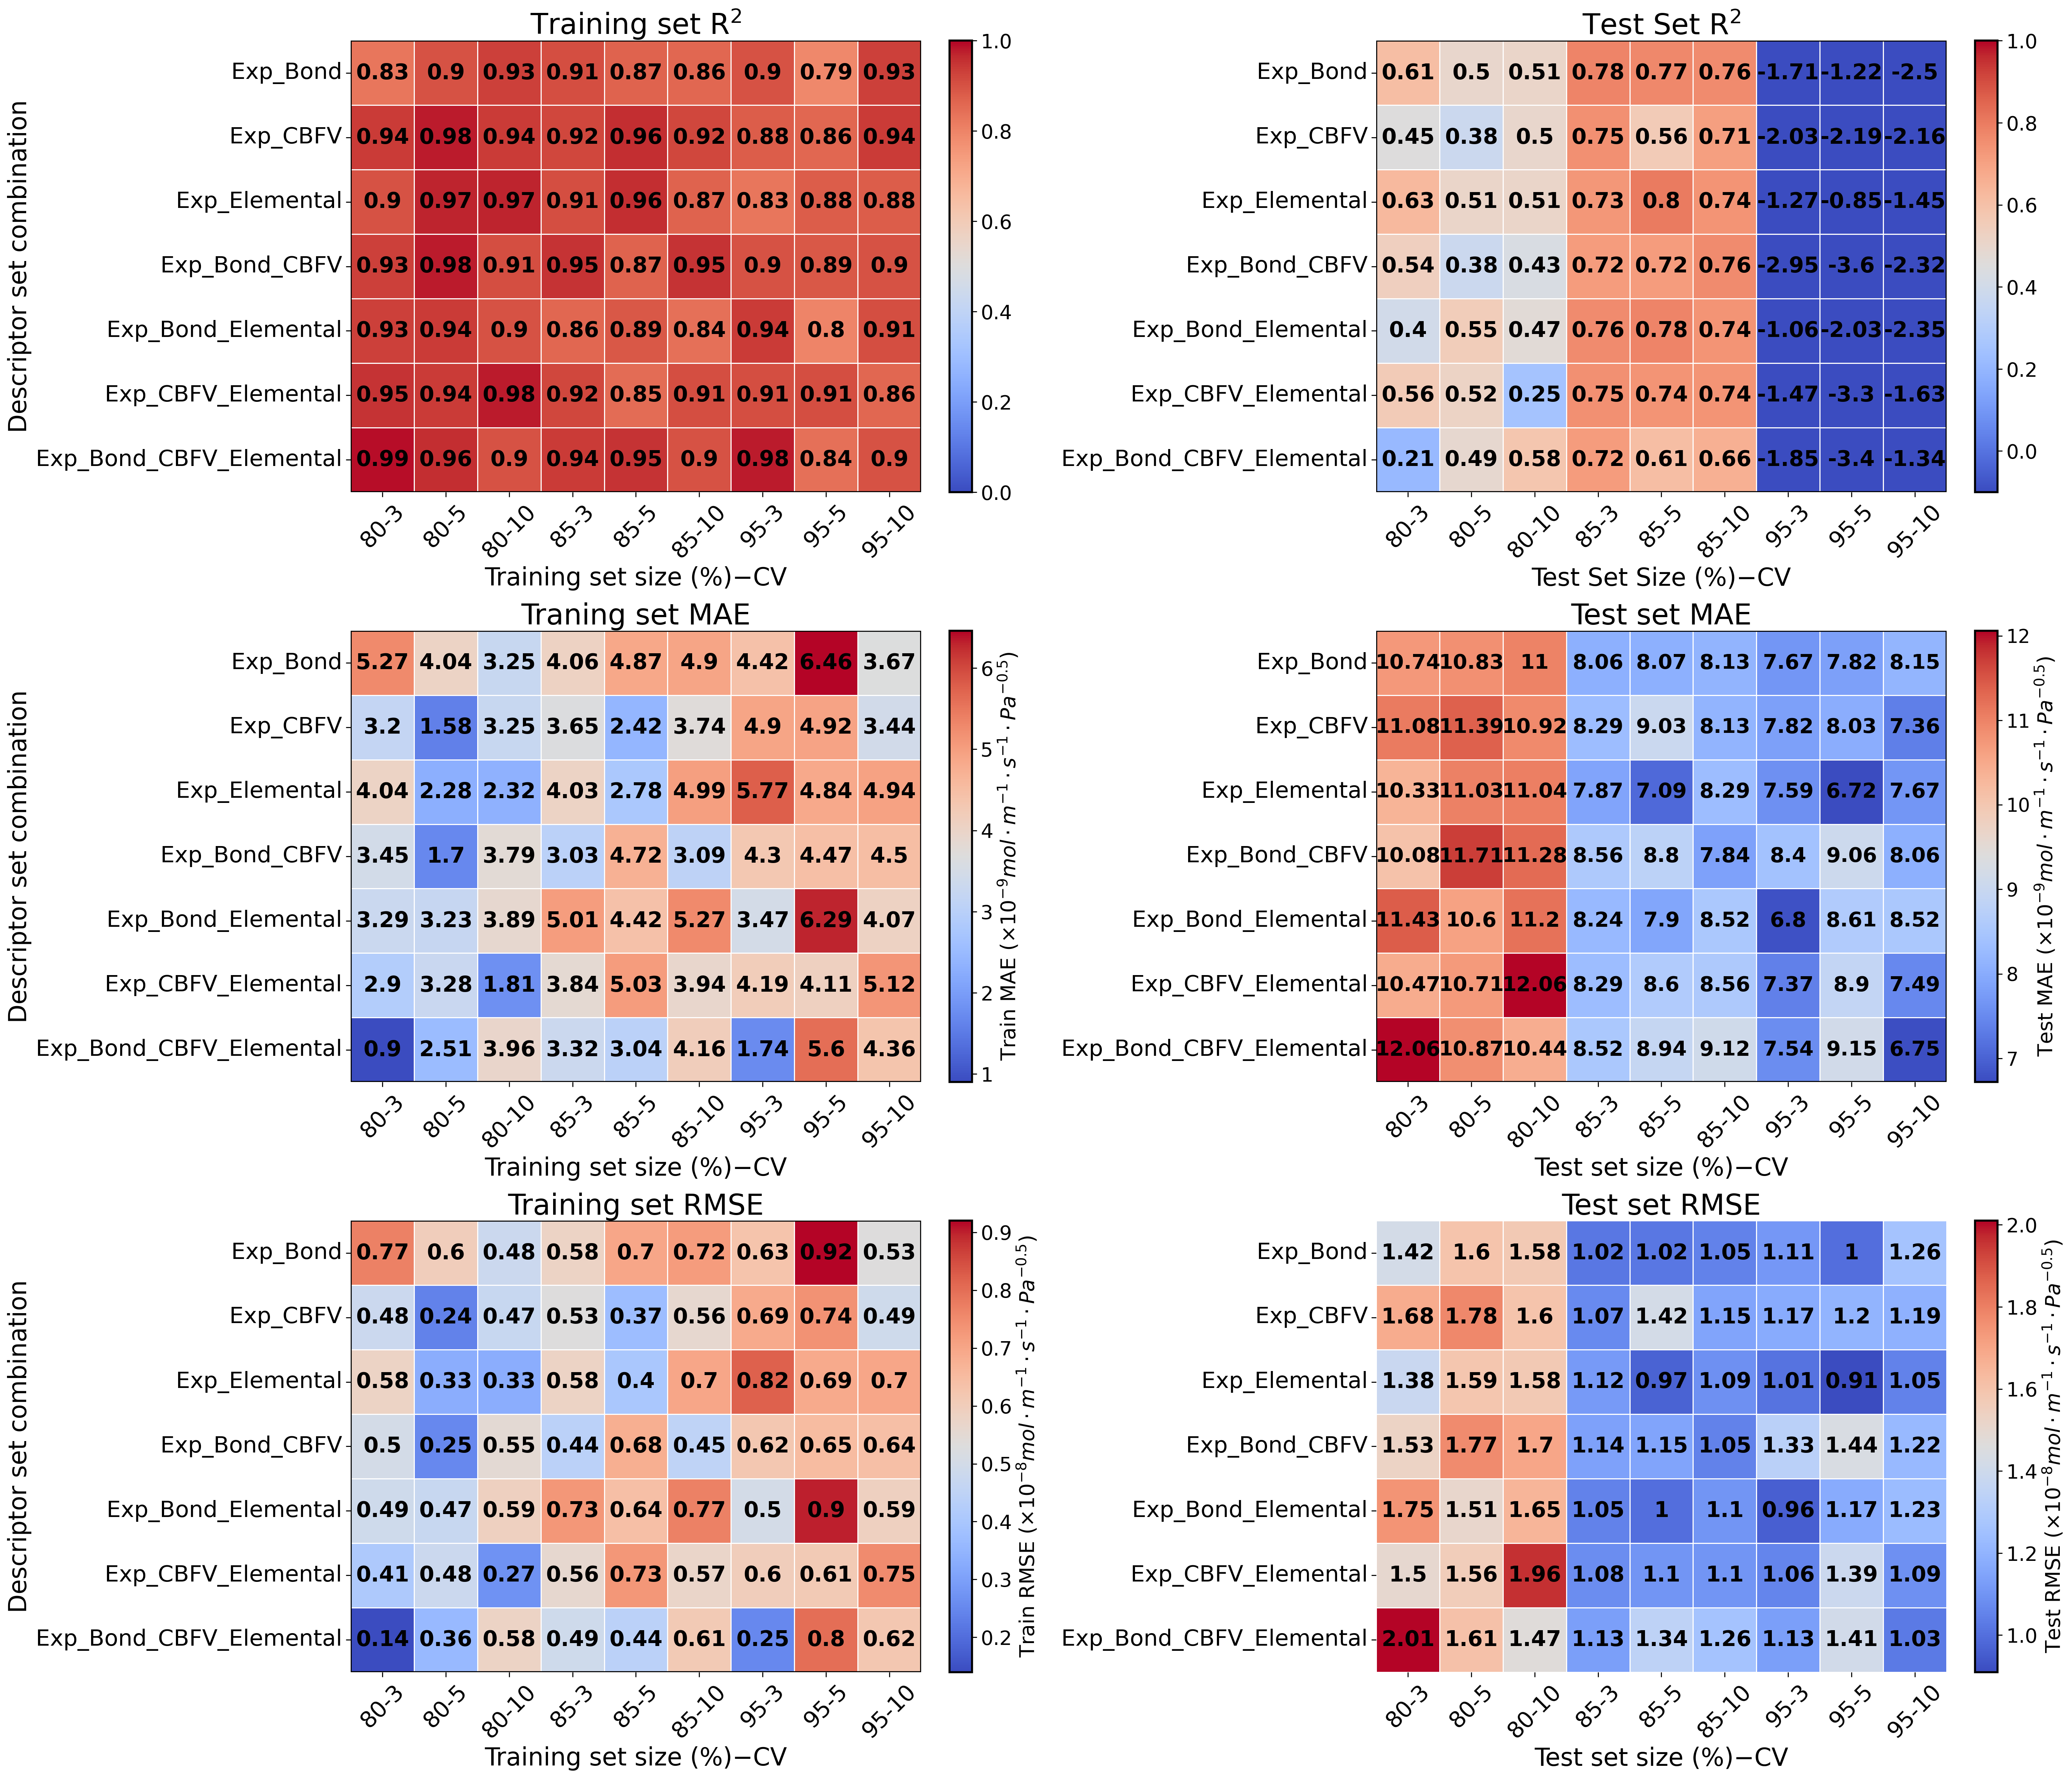

CPU times: user 9.45 s, sys: 1.03 s, total: 10.5 s
Wall time: 10.6 s


In [ ]:
%%time
fig, axs= plt.subplots(3, 2, figsize=(28, 24), constrained_layout=True)  # A 2 x 3 grid
sns.set_context("paper", font_scale = 2.2,  rc = {"lines.linewidth": 1.6}) # , font_scale = 1.6,  rc = {"lines.linewidth": 1.6}

# ##############################################################################
# Plot r2_train
# sns.set_context("paper")
# r2_train = sns.heatmap(plot_results_score['train_R2'], annot=True, cmap='coolwarm', fmt='g', annot_kws={"size":12, 'weight':'bold'}, cbar_kws={"shrink": 0.6}, linewidths=2.5, square=True, linecolor='black', ax=axs[0, 0]) square=True, 'weight':'bold'
r2_train = sns.heatmap(plot_results_score['train_R2'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, vmin=0, vmax=1.0, linewidths=1.0,  linecolor='white', ax=axs[0, 0])
cbar = axs[0, 0].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
r2_train.set_xlabel(xlabel=r'Training set size (%)−CV', fontsize =24) #
r2_train.set_ylabel(ylabel='Descriptor set combination', fontsize=24) #
r2_train.set_title(r'Training set $\mathrm{{R^{2}}}$', fontsize=28) #

# r2_train.set_xticklabels(labels=r2_train.get_xticklabels(), fontsize=20, rotation=45)
r2_train.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45) #

# r2_train.set_yticklabels(labels=r2_train.get_yticklabels())
r2_train.set_yticklabels(labels=[label.get_text() for label in r2_train.get_yticklabels()], fontsize=22) #

# Get dimensions of the heatmap
num_rows = len(axs[0, 0].get_yticklabels())
num_cols = len(axs[0, 0].get_xticklabels())

# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                    # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)
# Add the rectangle to the heatmap axis
axs[0, 0].add_patch(rect)

# # ###########################################################################################################################
# # Plot r2_test
sns.set_context("paper", font_scale = 2.2, rc = {"lines.linewidth": 1.6})
# sns.set_context("paper",font_scale = 2.5,  rc = {"lines.linewidth": 2.5})
# # r2_test = sns.heatmap(plot_results_score['test_R2'], annot=True, cmap='coolwarm', fmt='g', annot_kws={"size":12, 'weight':'bold'}, cbar_kws={"shrink": 0.6}, linewidths=2.5, square=True, linecolor='black', ax=axs[0, 0]) square=True, , 'weight':'bold'
r2_test = sns.heatmap(plot_results_score['test_R2'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, vmin=-0.1, vmax=1.0, linewidths=1.0,  linecolor='white', ax=axs[0, 1])
cbar = axs[0, 1].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
r2_test.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45)
r2_test.set_xlabel(xlabel=r'Test Set Size (%)−CV', fontsize =24)
r2_test.set_ylabel(ylabel=None)
r2_test.set_title(r'Test Set $\mathrm{{R^{2}}}$', fontsize=28)
# r2_test.set_xticklabels(labels=r2_test.get_xticklabels(), fontsize=20, rotation=45)

# r2_train.set_yticklabels(labels=r2_train.get_yticklabels(), fontweight='bold', fontsize=16)
r2_test.set_yticklabels(labels=[label.get_text() for label in r2_test.get_yticklabels()], fontsize=22)

# Get dimensions of the heatmap
num_rows = len(axs[0, 1].get_yticklabels())
num_cols = len(axs[0, 1].get_xticklabels())

# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                     # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)

# Add the rectangle to the heatmap axis
axs[0, 1].add_patch(rect)

# #########################################################################################################################
# # #Plot train_MAE
sns.set_context("paper", font_scale = 2.2, rc = {"lines.linewidth": 1.6})
# r2_test = sns.heatmap(plot_results_score['test_R2'], annot=True, cmap='coolwarm', fmt='g', annot_kws={"size":12, 'weight':'bold'}, cbar_kws={"shrink": 0.6}, linewidths=2.5, square=True, linecolor='black', ax=axs[0, 0]) square=True, , 'weight':'bold'
MAE_train = sns.heatmap(plot_results_score['train_MAE'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, linewidths=1.0,  linecolor='white', ax=axs[1, 0])
cbar = axs[1, 0].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
cbar.ax.set_ylabel(r'$\mathrm{Train~MAE}~(\times 10^{-9} mol \cdot m^{-1} \cdot s^{-1} \cdot Pa^{-0.5})$', fontsize=20) # Add labelpad=15
MAE_train.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45)
MAE_train.set_xlabel(xlabel=r'Training set size (%)−CV', fontsize =24)
MAE_train.set_ylabel(ylabel='Descriptor set combination', fontsize=24)
MAE_train.set_title(r'Traning set MAE', fontsize=28)

# MAE_train.set_xticklabels(labels=MAE_train.get_xticklabels(), fontsize=20, rotation=45)
# r2_train.set_yticklabels(labels=r2_train.get_yticklabels(), fontweight='bold', fontsize=16)
MAE_train.set_yticklabels(labels=[label.get_text() for label in MAE_train.get_yticklabels()], fontsize=22)

# Get dimensions of the heatmap
num_rows = len(axs[1, 0].get_yticklabels())
num_cols = len(axs[0, 1].get_xticklabels())

# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                     # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)
# Add the rectangle to the heatmap axis
axs[1, 0].add_patch(rect)

# #################################################################################################################################################
# # #Plot test_MAE
sns.set_context("paper", font_scale = 2.1, rc = {"lines.linewidth": 1.6})
MAE_test = sns.heatmap(plot_results_score['test_MAE'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, linewidths=1.0,  linecolor='white', ax=axs[1, 1])
cbar = axs[1, 1].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
cbar.ax.set_ylabel(r'$\mathrm{Test~MAE}~(\times 10^{-9} mol \cdot m^{-1} \cdot s^{-1} \cdot Pa^{-0.5})$', fontsize=20) # Add labelpad=15
MAE_test.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45)
MAE_test.set_xlabel(xlabel = r'Test set size (%)−CV', fontsize =24)
MAE_test.set_ylabel(ylabel=None, fontsize=24)
MAE_test.set_title(r'Test set MAE', fontsize=28)
# MAE_test.set_xticklabels(labels=MAE_test.get_xticklabels(), fontsize=20, rotation=45)
# r2_train.set_yticklabels(labels=r2_train.get_yticklabels(), fontweight='bold', fontsize=16)
MAE_test.set_yticklabels(labels=[label.get_text() for label in MAE_train.get_yticklabels()], fontsize=22)
# Get dimensions of the heatmap
num_rows = len(axs[1, 1].get_yticklabels())
num_cols = len(axs[1, 1].get_xticklabels())
# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                     # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)
# Add the rectangle to the heatmap axis
axs[1, 1].add_patch(rect)

########################################################################################################################################################
# #Plot train_RMSE
sns.set_context("paper", font_scale = 2.2, rc = {"lines.linewidth": 1.6})
RMSE_train = sns.heatmap(plot_results_score['train_RMSE'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, linewidths=1.0,  linecolor='white', ax=axs[2, 0])
cbar = axs[2, 0].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
cbar.ax.set_ylabel(r'$\mathrm{Train~RMSE}~(\times 10^{-8} mol \cdot m^{-1} \cdot s^{-1} \cdot Pa^{-0.5})$', fontsize=20) # Add labelpad=15
RMSE_train.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45)
RMSE_train.set_xlabel(xlabel=r'Training set size (%)−CV', fontsize =24)
RMSE_train.set_ylabel(ylabel='Descriptor set combination', fontsize=24)
RMSE_train.set_title(r'Training set RMSE', fontsize=28)
# RMSE_train.set_xticklabels(labels=RMSE_train.get_xticklabels(), fontsize=20, rotation=45)
# r2_train.set_yticklabels(labels=r2_train.get_yticklabels(), fontweight='bold', fontsize=16)
RMSE_train.set_yticklabels(labels=[label.get_text() for label in MAE_train.get_yticklabels()], fontsize=22)

# Get dimensions of the heatmap
num_rows = len(axs[2, 0].get_yticklabels())
num_cols = len(axs[2, 0].get_xticklabels())

# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                     # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)

# Add the rectangle to the heatmap axis
axs[2, 0].add_patch(rect)

# ##################################################################################################################################################
# #Plot test_RMSE
sns.set_context("paper", font_scale = 2.2, rc = {"lines.linewidth": 1.6})
RMSE_test = sns.heatmap(plot_results_score['test_RMSE'], annot=True, cmap='coolwarm', fmt='g', annot_kws={'weight':'bold', 'color':'black'}, cbar_kws={"shrink": 1}, linewidths=1.0,  linecolor='white', ax=axs[2, 1])
cbar = axs[2, 1].collections[0].colorbar
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(2)
cbar.ax.set_ylabel(r'$\mathrm{Test~RMSE}~(\times 10^{-8} mol \cdot m^{-1} \cdot s^{-1} \cdot Pa^{-0.5})$', fontsize=20)
RMSE_test.set_xticklabels(['80-3', '80-5', '80-10', '85-3', '85-5', '85-10', '95-3', '95-5', '95-10'], fontsize=22, rotation=45)
RMSE_test.set_xlabel(xlabel=r'Test set size (%)−CV', fontsize=24)
RMSE_test.set_ylabel(ylabel=None, fontsize=22)
RMSE_test.set_title(r'Test set RMSE', fontsize=28)

RMSE_test.set_xticklabels(labels=RMSE_test.get_xticklabels(), fontsize=22, rotation=45)
RMSE_test.set_yticklabels(labels=[label.get_text() for label in RMSE_test.get_yticklabels()], fontsize=22)

# Get dimensions of the heatmap
num_rows = len(axs[2, 1].get_yticklabels())
num_cols = len(axs[2, 1].get_xticklabels())
# Add a rectangle patch around the heatmap
rect = patches.Rectangle(
    (0, 0),                     # bottom-left corner (x, y)
    num_cols,                  # width
    num_rows,                  # height
    linewidth=2,               # desired border thickness
    edgecolor='black',         # border color
    facecolor='none'           # keep inside transparent
)
# Add the rectangle to the heatmap axis
# axs[2, 1].add_patch(rect)

# Save
mpl.rcParams['svg.fonttype']='none'
# fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.5)
fig.savefig(fname='/content/drive/MyDrive/PhD_Pd alloy prediction/Figures_Pd_Permeability_Prediction/Result_HP_tuning_CPU_no_FS.svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()